In [14]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
import scipy
import copy
import os

In [15]:
df = pd.read_csv("data_interpolated.csv")
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Hour,Minute,T
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494.66,0,0,0
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,0,10,1
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,0,20,2
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,0,30,3
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,0,40,4


In [16]:
df = df.sort_values("T").reset_index(drop=True)
split1 = int(df.shape[0]*0.7)
split2 = int(df.shape[0]*0.8)
train = df.iloc[:split1] # 70%
validate = df.iloc[split1:split2] # 10%
test = df.iloc[split2:] # 20%

Setup: We have ground truth data over a graph but some of the values were missing and have been linearly interpolated. That means we can treat those interpolated values as having noise x' = x + n. We can extract the original x by doing regularization.

However because we don't have the ground truth of the missing values, there is no way to validate the performance of the regularizer. 

Option A: Add noise to the true values but not the interpolated ones. Run regularization on all of the points and measure performance based only on the noisy true values. 

Problem: Tikhonov regularizer assumes uniform noise. This means we have to use a custom regularizer and can't use Tikhonov out of the box

Option B: Use mask M to only regularize over interpolated values

Problem: No way to validate regularized values

In [17]:
turbines = pd.read_csv("turbines.csv")
turbines.head()

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175


In [18]:
G = nx.Graph()
turbines.apply(lambda x: G.add_node(int(x.TurbID), pos=(x.x, x.y)), axis=1)
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134))

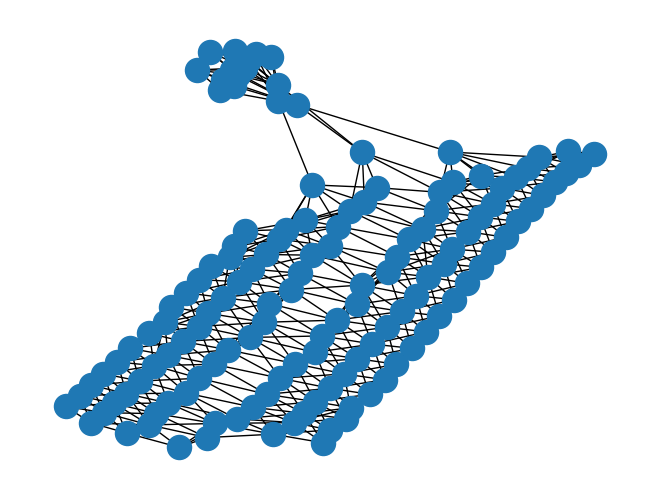

In [19]:
def construct_graph(turbine1, turbine2, max_distance):
    n1 = int(turbine1.TurbID)
    n2 = int(turbine2.TurbID)
    if n1 > n2:
        distance = np.sqrt((turbine2.x - turbine1.x)**2 + (turbine2.y - turbine1.y)**2)
        if distance <= max_distance:
            G.add_edge(n1, n2)
turbines.apply(lambda x: turbines.apply(lambda y: construct_graph(x,y,1500),axis=1),axis=1)
nx.draw(G)

Okay but this graph is only for one time step. We will have to use graph-time learning

Option A: construct a product graph

For now let's focus on a Cartesian product graph. Building the complete graph seems to be infeasible. Building for 100 minutes resulted in graph containing 1600 out of a total 25000 time steps.

In [20]:
graph_filename = "cartesian.edgelist"
if os.path.exists(graph_filename):
    GT = nx.read_edgelist(path=graph_filename, delimiter=":")
else:
    GT = nx.Graph()
    for t in range(train["T"].max()+1):
        GT = nx.union(GT, G, rename=("", f"{t}_"))
        if t > 0:
            for node in G.nodes:
                GT.add_edge(f"{t-1}_{node}", f"{t}_{node}")
    #nx.write_edgelist(GT, path=graph_filename, delimiter=":")

In [21]:
L = nx.laplacian_matrix(GT)
L = torch.sparse_coo_tensor(L.nonzero(), L.data, L.shape)

In [22]:
train_subset = train.iloc[:L.shape[0]]
y = torch.Tensor(train_subset["Patv"])

In [23]:
diagonal_vector = torch.Tensor(train_subset.isna().any(axis=1).astype(int))
n = len(diagonal_vector)

# Indices for the sparse matrix (row, column)
indices = torch.stack([
    torch.arange(n),  # row indices
    torch.arange(n)   # column indices (same as row for diagonal)
], dim=0)

In [24]:
M = torch.sparse_coo_tensor(
    indices=indices,
    values=diagonal_vector,
    size=(n, n),
    dtype=torch.float32
)

In [25]:
type(L)

torch.Tensor

In [30]:
M.device, L.device, y.device

(device(type='cpu'), device(type='cpu'), device(type='cpu'))

Torch has no sparse matrix inversion. Switch everything to scipy...

In [33]:
alpha = 0.1
x = torch.matmul(torch.matmul(torch.matmul(torch.linalg.inv(torch.matmul(M.T,M)+alpha*L), M.T), M), y)


NotImplementedError: Could not run 'aten::linalg_inv_ex' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::linalg_inv_ex' is only available for these backends: [CPU, CUDA, HIP, MPS, IPU, XPU, HPU, VE, MTIA, MAIA, PrivateUse1, PrivateUse2, PrivateUse3, Meta, FPGA, Vulkan, Metal, QuantizedCPU, QuantizedCUDA, QuantizedHIP, QuantizedMPS, QuantizedIPU, QuantizedXPU, QuantizedHPU, QuantizedVE, QuantizedMTIA, QuantizedMAIA, QuantizedPrivateUse1, QuantizedPrivateUse2, QuantizedPrivateUse3, QuantizedMeta, CustomRNGKeyId, MkldnnCPU, SparseCsrCPU, SparseCsrCUDA, SparseCsrHIP, SparseCsrMPS, SparseCsrIPU, SparseCsrXPU, SparseCsrHPU, SparseCsrVE, SparseCsrMTIA, SparseCsrMAIA, SparseCsrPrivateUse1, SparseCsrPrivateUse2, SparseCsrPrivateUse3, SparseCsrMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Undefined: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU_1.cpp:13755 [kernel]
CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA_0.cpp:55538 [kernel]
HIP: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
MPS: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
IPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
XPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
HPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
VE: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
MTIA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
MAIA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
PrivateUse1: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
PrivateUse2: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
PrivateUse3: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
Meta: registered at /home/benni/vsc/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_meta_registrations.py:50 [kernel]
FPGA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
Vulkan: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
Metal: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedCPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedCUDA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedHIP: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedMPS: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedIPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedXPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedHPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedVE: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedMTIA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedMAIA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedPrivateUse1: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedPrivateUse2: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedPrivateUse3: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
QuantizedMeta: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
CustomRNGKeyId: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
MkldnnCPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrCPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrCUDA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrHIP: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrMPS: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrIPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrXPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrHPU: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrVE: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrMTIA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrMAIA: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrPrivateUse1: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrPrivateUse2: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrPrivateUse3: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
SparseCsrMeta: registered at /pytorch/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional_0.cpp:24523 [default backend kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:387 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:115 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradHIP: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradMPS: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradIPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradXPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradVE: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradLazy: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradMTIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradMAIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradMeta: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:19687 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_3.cpp:15107 [kernel]
AutocastCPU: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:329 [kernel]
AutocastMTIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:468 [backend fallback]
AutocastMAIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:506 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:544 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/BatchRulesLinearAlgebra.cpp:735 [kernel]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]


Option B: Add regularization term over time to objective. This is equivalent to disjoint graph-time learning

$$\hat x = \arg\min_x||M_g(y_g-x_g)||_2^2+\gamma_1 x^TLx + \gamma_2 ||M_t(y_t-x_t)||_2^2$$

We can't expand y and x to be matrices instead of vectors as that would mess with the dimensionality of the regularization term $\gamma x^TLx$

In [ ]:
def tikhonov_time(x, y, L, M, reg_para, time_para):
    return torch.norm(torch.matmul(M, y-x), p=2)**2 + reg_para * torch.matmul(torch.matmul(x.T, L), x) + time_para * torch.norm(y-x, p=2)**2


In [ ]:
L = nx.laplacian_matrix(G)

In [ ]:
L.shape

(134, 134)

# Validation

Option A: Mask known values and check accuracy

Option B: Stability analysis. Plot over hyperparameter